## Evaluate impact of imageCoCenter with auxTel data 

Ticket:  https://jira.lsstcorp.org/browse/DM-36840
        


In [1]:
import yaml
import os
import numpy as np
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)

from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

from astropy.visualization import ZScaleInterval

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [ ]:
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

For auxTel the  fov is 6.7 arcmin, rather than 3.5 degrees ... https://noirlab.edu/public/programs/vera-c-rubin-observatory/rubin-auxtel/ 



In [17]:
def imageCoCenterRadialShiftAtFOV(inst, fov=3.5, debugLevel=0, plot=True,
                                 maxFieldDist = None):
    # Shift in the radial direction
    # The field of view (FOV) of LSST camera is 3.5 degree
    offset = inst.defocalDisOffsetInM 
    pixelSize = inst.pixelSize
    
    radialShift = fov * (offset/ 1e-3) * (10e-6 / pixelSize)
    print(f'defocal  offset in meters: {offset}, pixel size in meters: {pixelSize}')
    print(f'Field of view of the {inst._instName} telescope is {fov} degrees')
    print(f'radialShift at fov/2, i.e edge of fov is {radialShift} [px]')

    if plot:
        if maxFieldDist is None:
            maxFieldDist = fov/2
            
        fieldDist = np.linspace(0,maxFieldDist)
        fig,ax = plt.subplots(1,1,figsize=(6,4), dpi=100)
        ax.plot(fieldDist, radialShift * (fieldDist / (fov / 2)), '.--')
        ax.set_xlabel('fieldDist [degrees]')
        ax.set_ylabel('radialShift [px]')
        ax.set_title(f'{inst._instName} \noffset={offset*1000} mm, pixels {pixelSize*1e6} '+r'$\mu m$')
        
    # Calculate the projection of distance of donut to center
    #fieldDist = self._getFieldDistFromOrigin()
    #radialShift = radialShift * (fieldDist / (fov / 2))
    return radialShift 



configDir = getConfigDir()
inst = Instrument()

# inside estimateZernikes()
instName='auxTel'
camType = getCamType(instName)

# inside wfEsti.config
opticalModel = 'onAxis'
sizeInPix = 200  # aka donutStamps
inst.configFromFile(sizeInPix, camType)



Using the correct FOV :

defocal  offset in meters: 0.032799999999999996, pixel size in meters: 1e-05
Field of view of the auxTel telescope is 0.11166666666666666 degrees
radialShift at fov/2, i.e edge of fov is 3.662666666666666 [px]


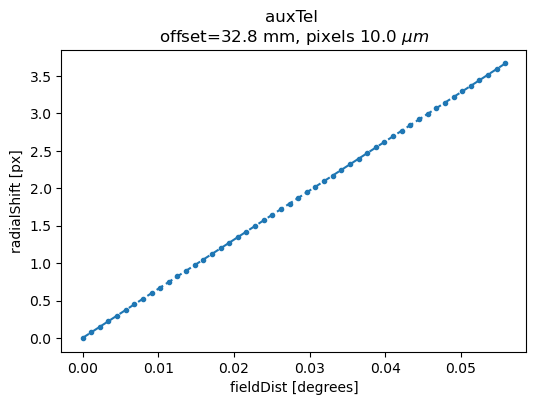

In [18]:
radialShift = imageCoCenterRadialShiftAtFOV(inst,fov=6.7/60, plot=True)

Because the FOV is so small (only 6.7 arcmin), the radialShift is small also (<3.5 px) which is properly remedied by the `recenter` step. But I don't think that this FOV is implemented at all, meaning a wrong FOV is assumed (with auxTel's defocal distance and the same pixel size as LSST), meaning that the calculated coCenter shift is way too large. If we assume fov=3.5 deg (as set by default in `imageCoCenter`, and not changed in `algorithm` call to that) , we get : 

defocal  offset in meters: 0.032799999999999996, pixel size in meters: 1e-05
Field of view of the auxTel telescope is 3.5 degrees
radialShift at fov/2, i.e edge of fov is 114.79999999999998 [px]


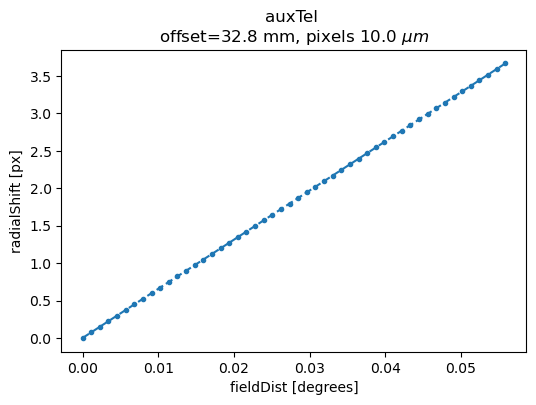

In [19]:
radialShift = imageCoCenterRadialShiftAtFOV(inst,fov=3.5, plot=True, maxFieldDist=6.7/2/60)


This is very close to true,  and still under 9 px, given the small field distance for `auxTel` donuts (up to 6.7/2 arcmin) which means that it should not matter for the Algorithm, as it is remedied at the `recenter` stage. 

## Rerun the AOS pipeline for some auxTel data

Use the default pipeline configs - same dataset as what was analyzed in https://github.com/suberlak/AOS/blob/main/AOS_DM-33113_auxTel_data_reduction.ipynb

    pipetask run  --data-query "exposure IN (2021090800487,2021090800488) AND instrument='LATISS' AND visit_system=0" -b /sdf/group/rubin/repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib  --output u/scichris/Latiss/DM-36840 --pipeline /sdf/home/s/scichris/link_to_scichris/link_to_ncsa_home_aos/ts_wep/tests/testData/pipelineConfigs/testLatissPipeline.yaml  --register-dataset-types


Read the data: 

In [20]:
import algoritm_functions as func

In [21]:
repo_dir='/sdf/group/rubin/repo/main/'
instrument='LATISS'
collection='u/scichris/Latiss/DM-36840'
detector=0
donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      detector=detector,
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      detector=detector,
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = func.get_butler_image(repo_dir,
                              instrument=instrument,
                              detector=detector,
                              collection=collection)

# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()
configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

Plot the image:

Text(0.5, 1.0, 'RXX_S00')

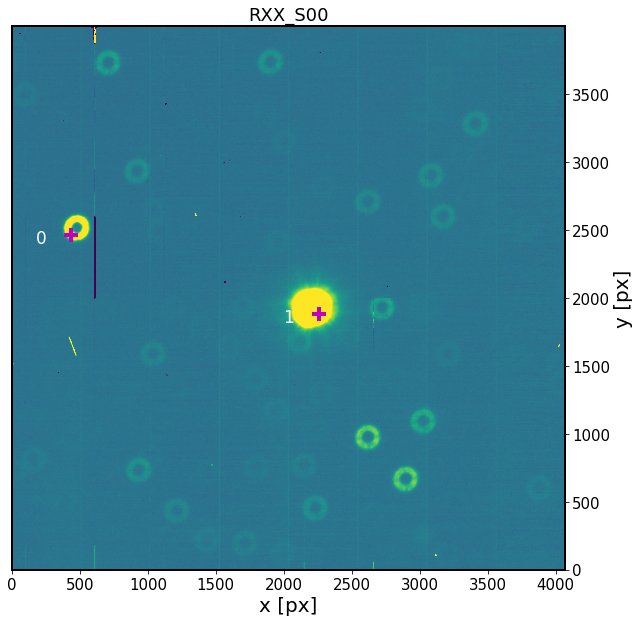

In [22]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
data= extraImage.image.array
vmin, vmax = zscale.get_limits(data)
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(data, origin='lower', vmin=vmin, vmax=vmax)
srcCat = extraFocalCatalog
nrows = len(srcCat)
exposureName = extraImage.getDetector().getName()
xs  = list(srcCat.centroid_x)
ys = list(srcCat.centroid_y)
for i in range(nrows):

    x = xs[i]
    y = ys[i]

    # plot the cross marking that the donut was used 
    ax.scatter(x,y,s=200,marker='+',c='m', lw=4)

    # plot the donut number on the plot 
    xtext,ytext = x,y
    ytext -= 60
    if xtext+100 > 4096:
        xtext -= 250
    if len(str(i))>1: # move to the left label thats too long 
        #print(i, 'moving')
        xtext -=340 
    else:
        xtext -=260
    ax.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
ax.yaxis.tick_right()
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.yaxis.set_label_position("right")
ax.set_title(f'{exposureName}')




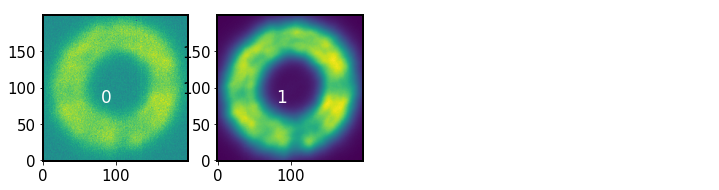

In [23]:
nDonuts = len(donutStampsExtra)
ncols=4
nrows= nDonuts//ncols
if nrows*ncols<nDonuts:
    nrows+=1
fig,axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
ax = np.ravel(axs)
for i in range(nDonuts):
    donut = donutStampsExtra[i]
    ax[i].imshow(donut.stamp_im.image.array, origin='lower')
    ax[i].text(80,80, f'{i}', fontsize=17, c='white')
fig.subplots_adjust(hspace=0.35)  

# if there are more axes than donuts,
# turn off the extra axes 
ncells = nrows*ncols
if ncells > nDonuts:
    for axis in ax[nDonuts:]:
        axis.axis("off")


Run the algoritm:

In [31]:
import importlib as imp
imp.reload(func)

<module 'algoritm_functions' from '/sdf/data/rubin/user/scichris/WORK/AOS/algoritm_functions.py'>

In [58]:
data_to_fit = 'auxtel' # 'auxtel'
dir_path = 'DM-36840'
# for simulated data
if data_to_fit == 'simulated' :
    instName='lsst'
    opticalModel = 'offAxis'
    sizeInPix = 160   # aka donutStamps 
    suffix = 'N'
    i=1 # use the same extra-focal donut for all intra-focal ones 

# for auxTel 
elif data_to_fit == 'auxtel':
    instName = 'auxTel'
    opticalModel = 'onAxis'
    sizeInPix = 200  # donut stamp size 
    suffix = 'auxTel'
    i=0
    j=0 # use the bright donut 

print(f'fitting {data_to_fit} data')
    

for doCoCenter in [True,False]:
    for j in range(len(donutStampsIntra)): # only one intra-focal donut 

        # this is part of the init
        inst = Instrument()
        algo = Algorithm(algoDir)

        # inside estimateZernikes()
        camType = getCamType(instName)

        # inside wfEsti.config
        inst.configFromFile(sizeInPix, camType)

        # choose the solver for the algorithm
        solver = 'exp' # by default
        debugLevel = 1 # 1 to 3
        algo.config(solver, inst, debugLevel=debugLevel)

        centroidFindType = CentroidFindType.RandomWalk
        imgIntra = CompensableImage(centroidFindType=centroidFindType)
        imgExtra = CompensableImage(centroidFindType=centroidFindType)

        # select the only donut pair in that corner
        donutExtra = donutStampsExtra[i]
        donutIntra = donutStampsIntra[j]

        # Inside EstimateZernikesBase
        # Transpose field XY because CompensableImages below are transposed
        # so this gets the correct mask orientation in Algorithm.py
        fieldXYExtra = donutExtra.calcFieldXY()[::-1]
        fieldXYIntra = donutIntra.calcFieldXY()[::-1]

        camera = donutExtra.getCamera() # same camera for both donuts
        detectorExtra = camera.get(donutExtra.detector_name)
        detectorIntra = camera.get(donutIntra.detector_name)


        # Rotate any sensors that are not lined up with the focal plane.
        # Mostly just for the corner wavefront sensors. The negative sign
        # creates the correct rotation based upon closed loop tests
        # with R04 and R40 corner sensors.
        eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
        eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

        # now inside  `wfEsti.setImg` method,
        # which inherits from `CompensableImage`
        imgExtra.setImg(fieldXYExtra,
                        DefocalType.Extra,
                        image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

        imgIntra.setImg(fieldXYIntra,
                        DefocalType.Intra,
                        image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

        boundaryT = algo.getBoundaryThickness()

        # right after we set the image, the compensable image mask is empty -
        # it is only calculated later in Algorithm
        maskScalingFactorLocal = 1


        # rename to just like it is in Algorithm.py
        algo, store = func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
                                  tol=1e-3,doCoCenter=doCoCenter)

        # save the values for that donut pair and cocenter
        coCenterText = 'noCocenter'
        if doCoCenter:
            coCenterText = 'doCocenter'

        fname = f'DM-36840_store_extra-{i}_intra-{j}_{coCenterText}_{suffix}.npy'
        fpath = os.path.join(dir_path,fname)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        print(fpath)
        np.save(fpath, store, )

fitting auxtel data
DM-36840/DM-36840_store_extra-0_intra-0_doCocenter_auxTel.npy
DM-36840/DM-36840_store_extra-0_intra-1_doCocenter_auxTel.npy
DM-36840/DM-36840_store_extra-0_intra-0_noCocenter_auxTel.npy
DM-36840/DM-36840_store_extra-0_intra-1_noCocenter_auxTel.npy


## Compare the final result with/without coCenter step

Diff sum: 0.0


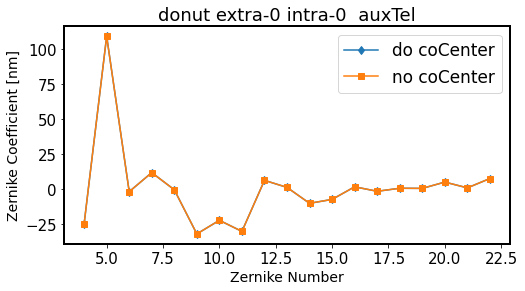

In [36]:
# using auxTel data
i=0
j=0

fname = f'DM-36840_store_extra-{i}_intra-{j}_doCocenter_{suffix}.npy'
fpath = os.path.join(dir_path,fname)
store0 = np.load(fpath, allow_pickle=True).item()

fname = f'DM-36840_store_extra-{i}_intra-{j}_noCocenter_{suffix}.npy'
fpath = os.path.join(dir_path,fname)
store1 = np.load(fpath, allow_pickle=True).item()

fig,ax = plt.subplots(1,1,figsize=(8,4))
zk0 = store0[14]['zer4UpNm']
zk1 = store1[14]['zer4UpNm']

plt.plot(np.arange(4, 23),zk0, '-d', label=f'do coCenter',
            )

plt.plot(np.arange(4, 23),zk1, '-s', label=f'no coCenter',
            )

plt.xlabel('Zernike Number', size=14)
plt.ylabel('Zernike Coefficient [nm]', size=14)
plt.legend(fontsize=17)
plt.title(f'donut extra-{i} intra-{j}  {suffix}')
print('Diff sum:', np.sum(zk0-zk1))

There is absolutely no difference. This is because the amount of shift applied by `coCenter` is :

In [42]:
store0[0]['intra']['cocenter_radialShift']

2.9473387086313316

i.e. less than 3 pixels radially. 

Prove that in the other case absolutely no shift was imparted (because the `imageCoCenter` step was skipped):

In [46]:
np.sum(store1[0]['intra']['imgBeforeCocenter']-store1[0]['intra']['imgAfterCocenter'])

0.0

Indeed - image arrays before and after that step are identical . Consider how much larger the `imageCoCenter` must be to make a difference:

## Run algorithm for the same bright donut, but increase the amount of `coCenter` shift

In [ ]:
if data_to_fit == 'auxtel':
    instName = 'auxTel'
    opticalModel = 'onAxis'
    sizeInPix = 200  # donut stamp size 
    suffix = 'auxTel'
    i=0
    j=0 # use the bright donut 
      
doCoCenter= True 
coCenterText = 'doCocenter'
for increaseFactor in  np.arange(1,3,0.05):
    for j in range(len(donutStampsIntra)): # only one intra-focal donut 
        fname = f'{dir_path}_store_extra-{i}_intra-{j}_{coCenterText}_increaseFactor-{increaseFactor}.npy'
        fpath = os.path.join(dir_path,fname)
        if  os.path.exists(fpath):
            print(f'{i} {j} {increaseFactor} {fpath} already exists, skipping')
        else:
            # this is part of the init
            inst = Instrument()
            algo = Algorithm(algoDir)

            # inside estimateZernikes()
            camType = getCamType(instName)

            # inside wfEsti.config
            inst.configFromFile(sizeInPix, camType)
            # choose the solver for the algorithm
            solver = 'exp' # by default
            debugLevel = 1 # 1 to 3
            algo.config(solver, inst, debugLevel=debugLevel)

            centroidFindType = CentroidFindType.RandomWalk
            imgIntra = CompensableImage(centroidFindType=centroidFindType)
            imgExtra = CompensableImage(centroidFindType=centroidFindType)

            # select the only donut pair in that corner
            donutExtra = donutStampsExtra[i]
            donutIntra = donutStampsIntra[j]

            # Inside EstimateZernikesBase
            # Transpose field XY because CompensableImages below are transposed
            # so this gets the correct mask orientation in Algorithm.py
            fieldXYExtra = donutExtra.calcFieldXY()[::-1]
            fieldXYIntra = donutIntra.calcFieldXY()[::-1]

            camera = donutExtra.getCamera() # same camera for both donuts
            detectorExtra = camera.get(donutExtra.detector_name)
            detectorIntra = camera.get(donutIntra.detector_name)


            # Rotate any sensors that are not lined up with the focal plane.
            # Mostly just for the corner wavefront sensors. The negative sign
            # creates the correct rotation based upon closed loop tests
            # with R04 and R40 corner sensors.
            eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
            eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

            # now inside  `wfEsti.setImg` method,
            # which inherits from `CompensableImage`
            imgExtra.setImg(fieldXYExtra,
                            DefocalType.Extra,
                            image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

            imgIntra.setImg(fieldXYIntra,
                            DefocalType.Intra,
                            image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

            boundaryT = algo.getBoundaryThickness()

            # right after we set the image, the compensable image mask is empty -
            # it is only calculated later in Algorithm
            maskScalingFactorLocal = 1


            # rename to just like it is in Algorithm.py
            algo, store = func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
                                      tol=1e-3,doCoCenter=doCoCenter, increaseFactor=increaseFactor)

            # save the values for that donut pair and cocenter
            coCenterText = 'noCocenter'
            if doCoCenter:
                coCenterText = 'doCocenter'

            print(fpath)
            np.save(fpath, store, )

Plot the results:

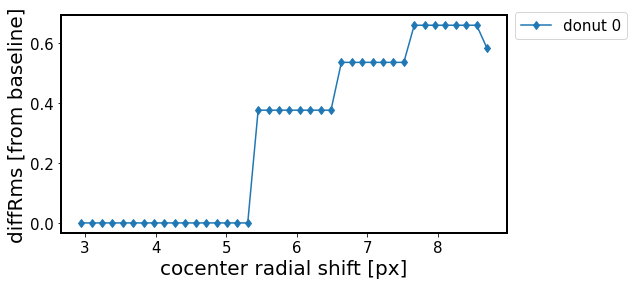

In [62]:
i=0

fig,ax = plt.subplots(1,1,figsize=(8,4))

for j in range(1):
    coCenterText = 'doCocenter'
    # baseline
    fname = f'{dir_path}_store_extra-{i}_intra-{j}_{coCenterText}_{suffix}.npy'
    fpath= os.path.join(dir_path,fname)
    store0 = np.load(fpath, allow_pickle=True).item()
    zk0 = store0[14]['zer4UpNm']
    shift0 = store0[0]['intra']['cocenter_radialShift']

    diffRms_=[]
    shift_=[]
    # find the diffRms as a function of shift for entire shift range
    for increaseFactor in np.arange(1,3,0.05):
        fname = f'{dir_path}_store_extra-{i}_intra-{j}_{coCenterText}_increaseFactor-{increaseFactor}.npy'
        fpath= os.path.join(dir_path,fname)
        #print(fname)
        store = np.load(fpath, allow_pickle=True).item()
        zk = store[14]['zer4UpNm']
        shift = store[0]['intra']['cocenter_radialShift']
        shift_.append(shift)
        diffRms = np.sqrt(np.sum(np.abs(zk - zk0) ** 2) / len(zk))
        diffRms_.append(diffRms)
        
    ax.plot(shift_,  diffRms_,'-d' , label=f'donut {j}')



    ax.set_xlabel('cocenter radial shift [px]')
    ax.set_ylabel('diffRms [from baseline]')
ax.legend(bbox_to_anchor=[1, 1.05])

So to get any appreciable difference, the amount of cocenter shift needed to be increased to 5.3 px. i.e. almost twice the baseline shift for that radial position. Note  - given the 6.7 arcmin fov, the maximum cocenter radial shift as shown on the first figure, is 3.5 px. 

This means that removing the `imageCoCenter` step would make no difference for analyzing `auxTel` data. And that also means that `fov` does not need to be fixed (as otherwise it would have to be changed when it is called in `algorithm` , perhaps it ought be  part of the `instrument` class as one of the instrument characteristics). 